# When to observe spotted stars

In [6]:
%matplotlib inline
import sys
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from gatspy import periodic

from astroplan import FixedTarget, Observer
import astropy.units as u
from astropy.time import Time

sys.path.insert(0, '/astro/users/bmmorris/git/hat-11/data/')
from datacleaner import LightCurve

apo = Observer.at_site("APO")
target = FixedTarget.from_name("GJ 1243")

## Read the Kepler light curve, fit with Lomb-Scargle periodogram with 4 terms

In [4]:
t0_jrad = Time(2454833.11567807, format='jd')
p_jrad = 0.592596

long_cadence_paths = glob('/media/PASSPORT/hcts/gj1243/*llc.fits')
gj1243 = LightCurve.from_raw_fits(long_cadence_paths, name='GJ1243')
gj1243.normalize_each_quarter()
model = periodic.LombScargle(fit_period=True, Nterms=4, optimizer_kwds={'quiet': True})
model.optimizer.period_range = (0.55, 0.65)
model.fit(gj1243.times.jd, gj1243.fluxes, gj1243.errors);
yfit = model.predict(gj1243.times.jd, period=model.best_period)

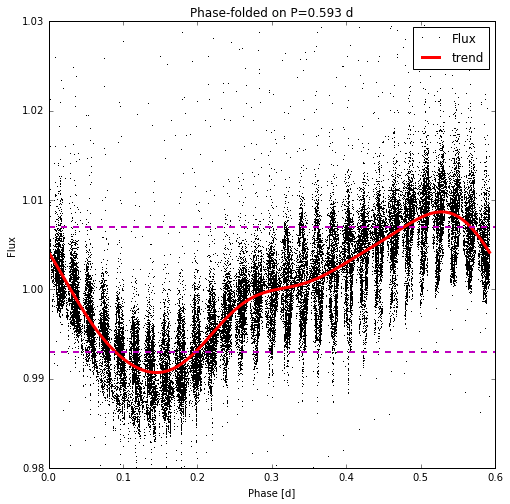

In [7]:
phase = gj1243.times.jd % model.best_period
tfit = np.linspace(0, model.best_period, 100)
yfit = model.predict(tfit, period=model.best_period)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phase, gj1243.fluxes, 'k,', label='Flux')
ax.plot(tfit, yfit, 'r', lw=3, label='trend')
ax.set(xlabel='Phase [d]', ylabel='Flux', title='Phase-folded on P={0:.3f} d'.format(model.best_period),
       ylim=(0.98, 1.03))
ax.axhline(1.007, color='m', ls='--', lw=2)
ax.axhline(0.993, color='m', ls='--', lw=2)
ax.legend()
plt.show()

## Observing constraint: observe near max/min of flux model 

In [8]:
from astroplan import Constraint
class ModelFluxConstraint(Constraint):
    def __init__(self, min=None, max=None, flux_model=None):
        """
        Parameters 
        ----------
        min : float
            Minimum model flux allowed
        max : float
            Maximum model flux allowed
        flux_model : function
            Function that takes one argument, the time, and returns the
            flux of the star at that time
        """
        self.min = min
        self.max = max
        self.flux_model = flux_model
    
    def compute_constraint(self, times, observer, targets):
        model_fluxes = self.flux_model(times)

        if self.min is None and self.max is not None:
            mask = self.max >= model_fluxes
        elif self.max is None and self.min is not None:
            mask = self.min <= model_fluxes
        elif self.min is not None and self.max is not None:
            mask = ((self.min <= model_fluxes) &
                    (model_fluxes <= self.max))
        else:
            raise ValueError("No max and/or min specified in "
                             "ModelFluxConstraint.")
        return np.atleast_2d(mask)

def flux_model(time):
    return model.predict(time.jd, period=model.best_period)
    
# c = ModelFluxConstraint(min=1.005, flux_model=flux_model)
# flux_observable = c(apo, [target], times=times)
# predicted_fluxes = model.predict(times.jd, period=model.best_period)
# plt.plot(times.jd[observable], predicted_fluxes[observable], 'k.')
# plt.plot(times.jd[observable & flux_observable],  predicted_fluxes[observable & flux_observable], 'r.')

Find the first possible date to observe this target for $n$ hours near the model max/min:

GJ 1243 is observable near flux max for at least 2.0 h for the first day on 2016-03-14
GJ 1243 is observable near flux min for at least 2.0 h for the first day on 2016-03-03


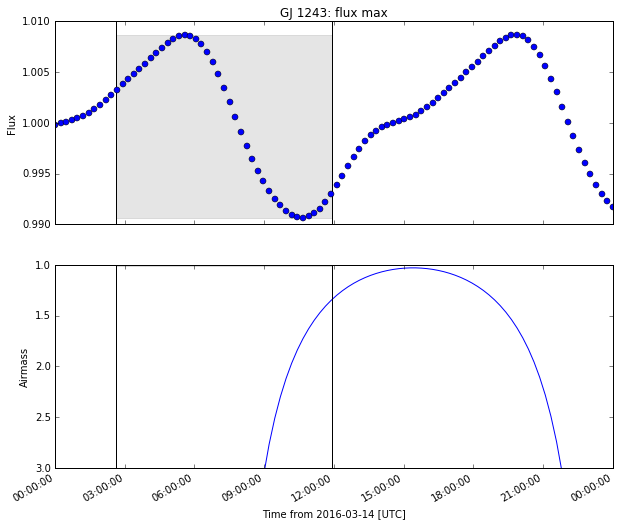

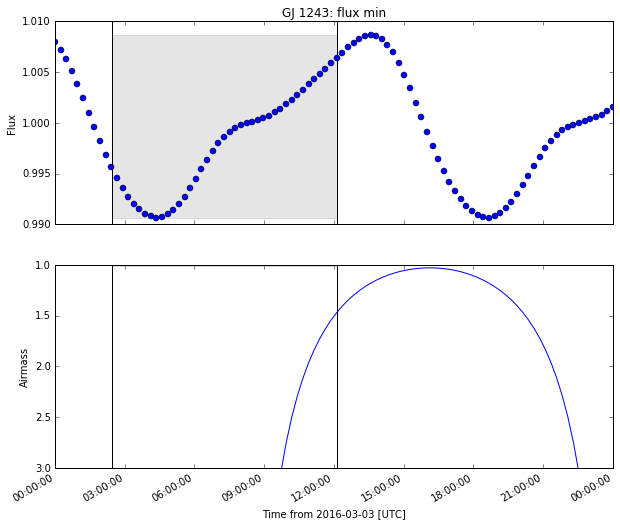

In [24]:
from astroplan import (AltitudeConstraint, AtNightConstraint, 
                       is_observable, observability_table, AirmassConstraint)
from astroplan.utils import time_grid_from_range
from astroplan.plots import plot_airmass
from astropy.coordinates import get_sun

near_max_flux = [AirmassConstraint(max=1.5), #AltitudeConstraint(min=30*u.deg), 
                 AtNightConstraint.twilight_astronomical(),
                 ModelFluxConstraint(min=1.007, flux_model=flux_model)]
near_min_flux = [AirmassConstraint(max=1.5), #AltitudeConstraint(min=30*u.deg), 
                 AtNightConstraint.twilight_astronomical(),
                 ModelFluxConstraint(max=0.993, flux_model=flux_model)]
min_up_duration = 2*u.hour
time_resolution = 0.5*u.hour
times = time_grid_from_range(Time(['2016-03-01', '2016-09-01']), time_resolution=time_resolution)

import numpy as np
max_observable = np.logical_and.reduce([c(apo, [target], times=times) for c in near_max_flux])[0]
min_observable = np.logical_and.reduce([c(apo, [target], times=times) for c in near_min_flux])[0]

for observable, label in zip([max_observable, min_observable], ["max", "min"]):
    all_dates_up = [dt.date() for dt in times[observable].datetime]
    unique_dates_up = list(set(all_dates_up))
    dates_up_long = []
    for unique_date in unique_dates_up:
        #print("{0} > {1}".format(all_dates_up.count(unique_date), float(min_up_duration/time_resolution)))
        if all_dates_up.count(unique_date) > float(min_up_duration/time_resolution):
            dates_up_long.append(unique_date)

    if len(dates_up_long) > 0:
        print("{0} is observable near flux {1} for at least {2} for the first day on {3}"
              .format(target.name, label, min_up_duration, sorted(dates_up_long)[0]))

        # Make plot
        plot_times = Time(str(sorted(dates_up_long)[0])) + np.linspace(0, 24, 100)*u.hour
        target_set = apo.target_set_time(plot_times[0], target, which='nearest')
        plot_fluxes = flux_model(plot_times)
        fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        plot_airmass(target, apo, plot_times, ax=ax[1])

        morn_astro_twilight = apo.twilight_morning_astronomical(plot_times[0], which='next')
        even_astro_twilight = apo.twilight_evening_astronomical(plot_times[0], which='next')
        for axis in ax:
            axis.axvline(morn_astro_twilight.plot_date, color='k')
            axis.axvline(even_astro_twilight.plot_date, color='k')

            axis.fill_between([even_astro_twilight.plot_date, morn_astro_twilight.plot_date], 
                              plot_fluxes.min(), plot_fluxes.max(), color='k', alpha=0.1)

        ax[0].plot_date(plot_times.plot_date, plot_fluxes)
        ax[0].set(ylabel='Flux', title="{0}: flux {1}".format(target.name, label))
        fig.savefig("{0} flux {1}.png".format(target.name, label).replace(" ", "_"), 
                    bbox_inches='tight')

## Cheap optimization: maximize altitude, observe nearest to flux max/min:

In [48]:
max_score = np.ones(len(times))
for constraint in near_min_flux:
    if constraint.__class__ == AirmassConstraint:
        altitude_score =  apo.altaz(times, target).alt.to(u.deg).value * (1./90)
        altitude_score[altitude_score < 30./90] = 0
        max_score *= altitude_score
        # Cut off those below 30 deg
    elif constraint.__class__ == AtNightConstraint:
        max_score *= constraint(apo, [target], times=times)[0].astype(float)
    elif constraint.__class__ == ModelFluxConstraint:
        model_fluxes = flux_model(times)
        max_score[model_fluxes < 1] = 0
        max_score *= (model_fluxes - 1)/np.max(model_fluxes - 1)
        
#plt.plot(score)#[:1500])
print(times[max_score > 0.8].iso)

['2016-06-03 10:00:00.061' '2016-06-06 09:00:00.063'
 '2016-06-06 09:30:00.063' '2016-06-19 10:00:00.071'
 '2016-06-22 09:00:00.073' '2016-06-22 09:30:00.073'
 '2016-06-25 08:00:00.075' '2016-06-25 08:30:00.075'
 '2016-06-28 07:30:00.077' '2016-07-11 08:00:00.085'
 '2016-07-11 08:30:00.085' '2016-07-14 07:00:00.087'
 '2016-07-14 07:30:00.087' '2016-07-17 06:30:00.089'
 '2016-07-17 07:00:00.089' '2016-08-02 06:30:00.099'
 '2016-08-05 05:30:00.101' '2016-08-05 06:00:00.101'
 '2016-08-08 05:00:00.103' '2016-08-21 05:30:00.112'
 '2016-08-24 04:30:00.113' '2016-08-24 05:00:00.113'
 '2016-08-27 04:00:00.115']


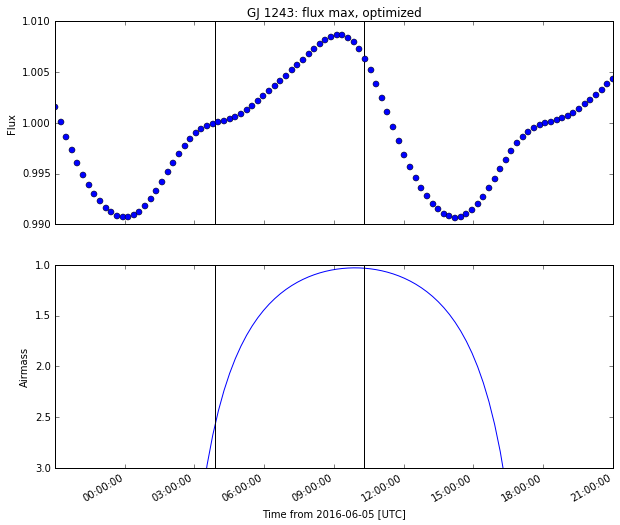

In [60]:
plot_times = Time('2016-06-06 09:00:00.063') + np.linspace(-12, 12, 100)*u.hour
target_set = apo.target_set_time(plot_times[0], target, which='nearest')
plot_fluxes = flux_model(plot_times)
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plot_airmass(target, apo, plot_times, ax=ax[1])

morn_astro_twilight = apo.twilight_morning_astronomical(plot_times[0], which='next')
even_astro_twilight = apo.twilight_evening_astronomical(plot_times[0], which='next')
for axis in ax:
    axis.axvline(morn_astro_twilight.plot_date, color='k')
    axis.axvline(even_astro_twilight.plot_date, color='k')

    #axis.fill_between([even_astro_twilight.plot_date, morn_astro_twilight.plot_date], 
    #                  plot_fluxes.min(), plot_fluxes.max(), color='k', alpha=0.1)

ax[0].plot_date(plot_times.plot_date, plot_fluxes)
ax[0].set(ylabel='Flux', title="{0}: flux max, optimized".format(target.name))
fig.savefig("{0} flux max optimized.png".format(target.name, label).replace(" ", "_"), 
           bbox_inches='tight')

In [56]:
min_score = np.ones(len(times))
for constraint in near_min_flux:
    if constraint.__class__ == AirmassConstraint:
        altitude_score =  apo.altaz(times, target).alt.to(u.deg).value * (1./90)
        altitude_score[altitude_score < 30./90] = 0
        min_score *= altitude_score
        # Cut off those below 30 deg
    elif constraint.__class__ == AtNightConstraint:
        min_score *= constraint(apo, [target], times=times)[0].astype(float)
    elif constraint.__class__ == ModelFluxConstraint:
        model_fluxes = flux_model(times)
        min_score[model_fluxes > 1] = 0
        min_score *= np.abs((-model_fluxes + 1))/np.abs(np.min(-model_fluxes + 1))
        
#plt.plot(score)#[:1500])
print(times[min_score > 0.8].iso)

['2016-05-17 10:30:00.050' '2016-05-20 09:30:00.052'
 '2016-05-20 10:00:00.052' '2016-06-02 10:00:00.060'
 '2016-06-05 09:30:00.062' '2016-06-05 10:00:00.062'
 '2016-06-08 08:30:00.064' '2016-06-08 09:00:00.064'
 '2016-06-08 09:30:00.064' '2016-06-11 08:00:00.066'
 '2016-06-11 08:30:00.066' '2016-06-18 10:00:00.070'
 '2016-06-21 09:00:00.072' '2016-06-21 09:30:00.072'
 '2016-06-21 10:00:00.072' '2016-06-24 08:30:00.074'
 '2016-06-24 09:00:00.074' '2016-06-24 09:30:00.074'
 '2016-06-27 07:30:00.076' '2016-06-27 08:00:00.076'
 '2016-06-27 08:30:00.076' '2016-06-30 07:00:00.078'
 '2016-06-30 07:30:00.078' '2016-06-30 08:00:00.078'
 '2016-07-10 08:30:00.085' '2016-07-10 09:00:00.085'
 '2016-07-13 07:30:00.086' '2016-07-13 08:00:00.086'
 '2016-07-13 08:30:00.086' '2016-07-16 06:30:00.088'
 '2016-07-16 07:00:00.088' '2016-07-16 07:30:00.088'
 '2016-07-19 06:00:00.090' '2016-07-19 06:30:00.090'
 '2016-07-19 07:00:00.090' '2016-07-22 05:30:00.092'
 '2016-07-22 06:00:00.092' '2016-07-29 07:30:0

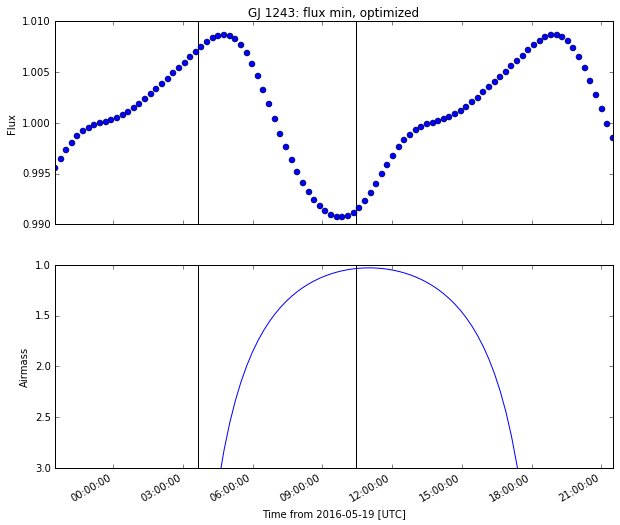

In [61]:
plot_times = Time('2016-05-20 09:30:00.052') + np.linspace(-12, 12, 100)*u.hour
target_set = apo.target_set_time(plot_times[0], target, which='nearest')
plot_fluxes = flux_model(plot_times)
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plot_airmass(target, apo, plot_times, ax=ax[1])

morn_astro_twilight = apo.twilight_morning_astronomical(plot_times[0], which='next')
even_astro_twilight = apo.twilight_evening_astronomical(plot_times[0], which='next')
for axis in ax:
    axis.axvline(morn_astro_twilight.plot_date, color='k')
    axis.axvline(even_astro_twilight.plot_date, color='k')

    #axis.fill_between([even_astro_twilight.plot_date, morn_astro_twilight.plot_date], 
    #                  plot_fluxes.min(), plot_fluxes.max(), color='k', alpha=0.1)

ax[0].plot_date(plot_times.plot_date, plot_fluxes)
ax[0].set(ylabel='Flux', title="{0}: flux min, optimized".format(target.name))
fig.savefig("{0} flux min optimized.png".format(target.name, label).replace(" ", "_"), 
           bbox_inches='tight')